In [1]:
import numpy as np
import math
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader

from torch.nn.init import normal, constant
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import torch.cuda
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Load data

In [4]:
images = np.load('images.npy')
targets = np.load('targets.npy')

In [5]:
unique_classes = np.unique(targets)
# class name -> integer
encode = {n: i for i, n in enumerate(unique_classes)}
# integer -> class name
decode = {i: n for i, n in enumerate(unique_classes)}

In [6]:
np.save('decode.npy', decode)

In [7]:
# encode class names by integers
targets = np.array([encode[n] for n in targets], dtype='int64')

# Standardize

In [8]:
# the values are taken from here 
# http://pytorch.org/docs/master/torchvision/models.html
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [9]:
images = images.astype('float32')
images /= 255.0

In [10]:
%%time
images -= mean
images /= std

CPU times: user 55.1 s, sys: 0 ns, total: 55.1 s
Wall time: 55.1 s


In [11]:
# transform to NCHW format
images = np.transpose(images, axes=(0, 3, 1, 2))

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(
    images, targets, 
    test_size=0.2, stratify=targets
)
print(len(X_train), len(X_val))

18317 4580


In [13]:
del images
del targets

# Data augmentation

In [14]:
data_generator = ImageDataGenerator(
    rotation_range=30, 
    zoom_range=0.05,
    horizontal_flip=True, 
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.0001,
    channel_shift_range=0.25,
    data_format='channels_first'
)

train_generator = data_generator.flow(
        X_train, Y_train,
        batch_size=len(X_train)
)

# Validation set

In [15]:
val_data = TensorDataset(
    torch.FloatTensor(X_val[:512]), 
    torch.LongTensor(Y_val[:512])
)

# Model

In [16]:
# load the SqueezeNet v1.1
squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.num_classes = 257

# reset the last layer
squeezenet.classifier = nn.Sequential(
    nn.Dropout(p=0.7),
    nn.Conv2d(512, 257, kernel_size=(1, 1), stride=(1, 1)),
    nn.ReLU(),
    nn.AvgPool2d(13)
)

# initialize the last layer's weights
normal(squeezenet.classifier[1].weight, std=0.01);
constant(squeezenet.classifier[1].bias, 0.0);

# list of all trainable parameters of the model
params = list(squeezenet.named_parameters())

# freeze all but the last two layers (fire module and conv. layer)
fixed_params = [
    p[1] for p in params 
    if not (
        ('classifier.1' in p[0]) or ('features.12' in p[0])
    )
]

for p in fixed_params:
    p.requires_grad = False

# all params in the last layer
params1 = [p for p in params if 'classifier.1' in p[0]]
params1_w = [p[1] for p in params1 if 'weight' in p[0]]
params1_b = [p[1] for p in params1 if 'bias' in p[0]]

# all params in the last fire module
params2 = [p for p in params if 'features.12' in p[0]]
params2_w = [p[1] for p in params2 if 'weight' in p[0]]
params2_b = [p[1] for p in params2 if 'bias' in p[0]]

# mend relu layers
squeezenet.features[1].inplace = False

for m in list(squeezenet.named_modules()):
    if 'activation' in m[0]:
        m[1].inplace = False

In [17]:
# loss function
criterion = nn.CrossEntropyLoss()

# set different learning rates 
conv_lr = 1e-3
fire_lr = 1e-9

optimizer = optim.SGD([
    {'params': params1_w, 'lr': conv_lr, 'weight_decay': 1e-4}, 
    {'params': params2_w, 'lr': fire_lr, 'weight_decay': 1e-9},
    {'params': params1_b, 'lr': conv_lr}, 
    {'params': params2_b, 'lr': fire_lr},
], momentum=0.7, nesterov=True)

# Train

In [18]:
def train(x_batch, y_batch):
    
    squeezenet.train()
    x_batch, y_batch = Variable(x_batch.cuda()), Variable(y_batch.cuda())
    optimizer.zero_grad()
    logits = squeezenet(x_batch)
    
    # compute logloss
    loss = criterion(logits, y_batch)
    batch_loss = loss.data[0]
    
    # compute accuracy
    pred = F.softmax(logits).max(1)[1]
    batch_accuracy = pred.eq(y_batch).float().mean().data[0]

    loss.backward()
    optimizer.step()
    return batch_loss, batch_accuracy

In [19]:
batch_size = 64
n_epochs = 30
validation_step = 150
regeneration_period = 11
n_batches = math.ceil(len(X_train)/batch_size)
n_batches

287

In [20]:
%%time
# generate initial data
x_chunk, y_chunk = train_generator.next()

train_data = TensorDataset(
    torch.FloatTensor(x_chunk), torch.LongTensor(y_chunk)
)
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True
)

CPU times: user 2min 17s, sys: 3.29 s, total: 2min 20s
Wall time: 2min 20s


In [21]:
# move the model to gpu
squeezenet.cuda();

In [22]:
all_losses = []

In [23]:
%%time
running_loss = 0.0
running_accuracy = 0.0 
start = time.time()

for epoch in range(0, n_epochs):
    for i, (x_batch, y_batch) in enumerate(train_loader, 1):

        batch_loss, batch_accuracy = train(x_batch, y_batch)
        running_loss += batch_loss
        running_accuracy += batch_accuracy
        step = i + epoch * n_batches
        
        if step % validation_step == 0:

            end = time.time()
            squeezenet.eval()
            x_val = Variable(val_data.data_tensor.cuda(), volatile=True)
            y_val = Variable(val_data.target_tensor.cuda(), volatile=True)
            logits = squeezenet(x_val)
            
            # compute logloss
            test_loss = criterion(logits, y_val).data[0]
            
            # compute accuracy
            pred = F.softmax(logits).max(1)[1]
            test_accuracy = pred.eq(y_val).float().mean().data[0]

            print('{0:.2f}  {1:.3f} {2:.3f}  {3:.3f} {4:.3f}  {5:.3f}'.format(
                step/n_batches, running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy, end - start
            ))
            all_losses += [(
                running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy
            )] 
            running_loss = 0.0
            running_accuracy = 0.0 
            start = time.time()
    
    if (epoch + 1) % regeneration_period == 0:
        print('dataset generation')
        x_chunk, y_chunk = train_generator.next()
        train_data = TensorDataset(
            torch.FloatTensor(x_chunk), torch.LongTensor(y_chunk)
        )
        train_loader = DataLoader(
            train_data, batch_size=batch_size, 
            shuffle=True, drop_last=True
        )

0.52  4.993 4.484  0.122 0.197  15.782
1.05  4.253 3.790  0.212 0.262  14.974
1.57  3.694 3.233  0.292 0.338  15.048
2.09  3.264 2.790  0.350 0.410  14.958
2.61  2.936 2.460  0.412 0.477  15.042
3.14  2.678 2.304  0.448 0.494  14.960
3.66  2.468 2.122  0.492 0.529  15.041
4.18  2.323 1.990  0.512 0.561  14.952
4.70  2.208 1.912  0.540 0.574  15.043
5.23  2.107 1.839  0.548 0.580  14.949
5.75  2.036 1.779  0.564 0.609  15.051
6.27  1.952 1.723  0.574 0.592  15.027
6.79  1.894 1.701  0.595 0.604  15.066
7.32  1.798 1.660  0.600 0.629  15.027
7.84  1.808 1.626  0.612 0.609  15.129
8.36  1.770 1.598  0.609 0.617  14.950
8.89  1.690 1.584  0.630 0.629  15.037
9.41  1.653 1.556  0.626 0.641  14.953
9.93  1.647 1.543  0.639 0.633  15.037
10.45  1.590 1.526  0.642 0.645  14.945
10.98  1.585 1.498  0.651 0.646  15.038
dataset generation
11.50  1.657 1.486  0.622 0.664  155.001
12.02  1.655 1.475  0.615 0.658  14.965
12.54  1.617 1.465  0.635 0.648  15.059
13.07  1.592 1.456  0.631 0.656  15.038

# Loss/epoch

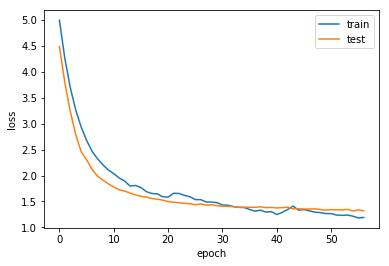

In [24]:
plt.plot([x[0] for x in all_losses], label='train');
plt.plot([x[1] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

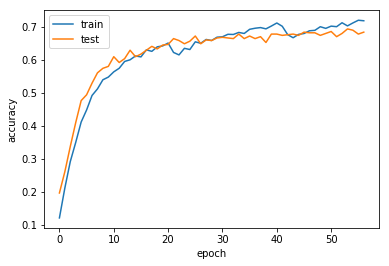

In [25]:
plt.plot([x[2] for x in all_losses], label='train');
plt.plot([x[3] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

# Accuracy on the rest of the val. set

In [26]:
true = Variable(torch.LongTensor(Y_val[-512:])).cuda()
pred = F.softmax(squeezenet(
    Variable(torch.FloatTensor(X_val[-512:]).cuda(), volatile=True)
)).max(1)[1]

In [27]:
accuracy = pred.eq(true).float().mean().data[0]
accuracy

0.666015625

In [28]:
# another part
true = Variable(torch.LongTensor(Y_val[-1024:-512])).cuda()
pred = F.softmax(squeezenet(
    Variable(torch.FloatTensor(X_val[-1024:-512]).cuda(), volatile=True)
)).max(1)[1]

In [29]:
accuracy = pred.eq(true).float().mean().data[0]
accuracy

0.67578125

# Test set predictions

In [30]:
test_images = np.load('test_images.npy')

In [31]:
test_images = test_images.astype('float32')
test_images /= 255.0

test_images -= mean
test_images /= std

test_images = np.transpose(test_images, axes=(0, 3, 1, 2))

In [32]:
test_probs = np.zeros((len(test_images), 5), dtype='float32')
test_classes = np.zeros((len(test_images), 5), dtype='int32')

In [33]:
for j, image in tqdm(enumerate(test_images)):
    
    image = np.expand_dims(image, 0)
    image = Variable(torch.FloatTensor(image).cuda(), volatile=True)
    
    test_probs[j] = F.softmax(
        squeezenet(image)
    ).cpu().sort(1, descending=True)[0][0][:5].data.numpy()
    
    test_classes[j] = F.softmax(
        squeezenet(image)
    ).cpu().sort(1, descending=True)[1][0][:5].data.numpy()

7710it [01:17, 98.99it/s]


In [34]:
np.save('test_probs.npy', test_probs)
np.save('test_classes.npy', test_classes)

# Save the model

In [35]:
torch.save(squeezenet.state_dict(), 'my_squeezenet.pytorch')